               id             @id addr:city addr:housenumber addr:place  \
0  node/173374079  node/173374079      None             None       None   
1  node/197352629  node/197352629      None             None       None   
2  node/197353072  node/197353072      None             None       None   
3  node/197353480  node/197353480      None             None       None   
4  node/197353596  node/197353596      None             None       None   

  addr:postcode addr:street alt_name alt_name:en amenity  ... survey:date  \
0          None        None     None        None    None  ...        None   
1          None        None     None        None    None  ...        None   
2          None        None     None        None    None  ...        None   
3          None        None     None        None    None  ...        None   
4          None        None     None        None    None  ...        None   

  tactile_paving traffic_sign  tram unsigned_ref   url visible_name website  \
0      

<AxesSubplot:>

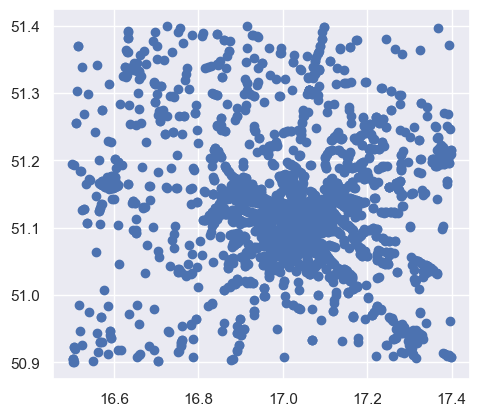

In [45]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import osmnx as ox
import folium
import scipy

import seaborn as sns
sns.set_theme()
import folium

gdf = gpd.read_file("data/mapa.geojson")

print(gdf.head())

gdf.plot()


In [17]:
import geopandas as gpd
import pandas as pd

gdf = gpd.read_file("data/mapa.geojson")

In [46]:
print(gdf.head())
print(gdf.columns)

               id             @id addr:city addr:housenumber addr:place  \
0  node/173374079  node/173374079      None             None       None   
1  node/197352629  node/197352629      None             None       None   
2  node/197353072  node/197353072      None             None       None   
3  node/197353480  node/197353480      None             None       None   
4  node/197353596  node/197353596      None             None       None   

  addr:postcode addr:street alt_name alt_name:en amenity  ... survey:date  \
0          None        None     None        None    None  ...        None   
1          None        None     None        None    None  ...        None   
2          None        None     None        None    None  ...        None   
3          None        None     None        None    None  ...        None   
4          None        None     None        None    None  ...        None   

  tactile_paving traffic_sign  tram unsigned_ref   url visible_name website  \
0      

In [47]:
import folium
m = folium.Map(location=[51.1078565, 17.04563742], zoom_start=15)

for _, row in gdf.iterrows():
    name = row['name']  
    lat = row['geometry'].y  
    lon = row['geometry'].x  
    folium.Marker(location=[lat, lon], popup=name).add_to(m)

filepath = "data/przystanki_map.html"
m.save(filepath)

m

In [12]:
G = nx.DiGraph()
df = pd.read_csv('data/graf_polaczen.csv', header=0, low_memory = False)

for _, row in df.iterrows():
    start = row['Przystanek startowy nazwa']
    end = row['Przystanek końcowy nazwa']
    time = row['Czas przejazdu']
    line = row['Linia']
    typ = row['Typ']
    
    if 'autobusowa' in typ:
        transport_type = 'autobus'
    else:
        transport_type = 'tramwaj'

    if G.has_edge(start, end):
        G[start][end]['count'] += 1
        G[start][end]['length'] = (G[start][end]['length'] * G[start][end]['count'] + time) / (G[start][end]['count'] + 1)
        G[start][end]['lines'].add(line)
        G[start][end]['transport'] = transport_type
    else:
        G.add_edge(start, end, count=1, length=time, lines={line}, transport=transport_type)

print(f"Graf ma {G.number_of_nodes()} węzłów i {G.number_of_edges()} krawędzi.")

Graf ma 958 węzłów i 8507 krawędzi.


In [14]:
gdf.head()

id             @id alt_name alt_name:en amenity bench   bin  \
0  node/173374079  node/173374079     None        None    None  None  None   
1  node/197352629  node/197352629     None        None    None  None  None   
2  node/246867001  node/246867001     None        None    None  None  None   
3  node/265643998  node/265643998     None        None    None  None  None   
4  node/265740396  node/265740396     None        None    None  None  None   

    bus bus_routes check_date  ... surface survey:date tactile_paving  \
0  None       None       None  ...    None        None           None   
1   yes       None       None  ...    None        None           None   
2   yes       None       None  ...    None        None           None   
3   yes       None       None  ...    None        None           None   
4  None       None       None  ...    None        None           None   

  traffic_sign  tram unsigned_ref visible_name website wheelchair  \
0         None   yes         None         None    None       None   
1         None  None         None         None    None       None   
2         None  None         None         None    None         no   
3         None  None         None         None    None       None   
4         None   yes         None         None    None       None   

                    geometry  
0  POINT (16.98540 51.09588)  
1  POINT (16.83466 51.04946)  
2  POINT (16.86967 51.01179)  
3  POINT (17.00638 51.11424)  
4  POINT (17.02977 51.10121)  

[5 rows x 82 columns]

In [54]:
import pandas as pd
import folium
import geopandas as gpd
from shapely.geometry import Point

df = pd.read_csv('data/graf_polaczen.csv', header=0, low_memory=False)

gdf = gpd.read_file("data/mapa.geojson")

m = folium.Map(location=[51.1078565, 17.04563742], zoom_start=15)

for _, row in gdf.iterrows():
    name = str(row['name']).lower()  
    lat = row['geometry'].y
    lon = row['geometry'].x
    folium.Marker([lat, lon], popup=name).add_to(m)

def get_coords_from_name(name, gdf):
    try:
        return gdf[gdf['name'].str.lower() == name.lower()].geometry.iloc[0]
    except IndexError:
        return None  

In [55]:
gdf_stop_names = gdf['name'].str.lower().tolist()
gdf_official_names = gdf['official_name'].dropna().str.lower().tolist()

missing_start_stops = df[~df['Przystanek startowy nazwa'].str.lower().isin(gdf_stop_names)]['Przystanek startowy nazwa'].unique()
missing_end_stops = df[~df['Przystanek końcowy nazwa'].str.lower().isin(gdf_stop_names)]['Przystanek końcowy nazwa'].unique()

def check_in_official_name(missing_stops, gdf_official_names):
    found_stops = [stop for stop in missing_stops if stop.lower() in gdf_official_names]
    return found_stops

missing_start_in_official = check_in_official_name(missing_start_stops, gdf_official_names)
missing_end_in_official = check_in_official_name(missing_end_stops, gdf_official_names)

print(f"Przystanki startowe, które znajdują się w 'official_name' w gdf: {len(missing_start_in_official)}")
print(missing_start_in_official)

print(f"Przystanki końcowe, które znajdują się w 'official_name' w gdf: {len(missing_end_in_official)}")
print(missing_end_in_official)


Przystanki startowe, które znajdują się w 'official_name' w gdf: 25
['pl. Bema', 'PL. GRUNWALDZKI', 'pl. Wróblewskiego', 'pl. Nowy Targ', 'pl. Zgody (Muzeum Etnograficzne)', 'PL. JANA PAWŁA II', 'pl. Strzegomski (Muzeum Współczesne)', 'DH Astra', 'PL. STASZICA', 'pl. Srebrny', 'pl. Legionów', 'Pl. Hirszfelda', 'pl. Daniłowskiego', 'Os. Przyjaźni', 'Serbska (C.K. Agora)', 'pl. Orląt Lwowskich', 'PL. SOLIDARNOŚCI', 'MIŃSKA (Rondo Rotm. Pileckiego)', 'Stanisławowska (W.K. Formaty)', 'C.H. Korona', 'rondo Św. Ojca Pio', 'C.H. Aleja Bielany', 'Suchy Dwór - skrzy. (Wrocławska/Główna)', 'Żórawina - skrzy. Niepodległości', 'Wysoka - Lipowa']
Przystanki końcowe, które znajdują się w 'official_name' w gdf: 24
['pl. Bema', 'PL. GRUNWALDZKI', 'pl. Wróblewskiego', 'pl. Nowy Targ', 'pl. Zgody (Muzeum Etnograficzne)', 'PL. JANA PAWŁA II', 'pl. Strzegomski (Muzeum Współczesne)', 'DH Astra', 'PL. STASZICA', 'pl. Srebrny', 'pl. Legionów', 'Pl. Hirszfelda', 'pl. Daniłowskiego', 'Os. Przyjaźni', 'Serbska 

In [62]:
import pandas as pd
import geopandas as gpd

gdf = gpd.read_file("data/mapa.geojson")

df = pd.read_csv("data/graf_polaczen.csv", header=0, low_memory=False)

def clean_name(name):
    if pd.isna(name):
        return None
    return ''.join(e for e in name if e.isalnum() or e.isspace()).strip().lower()

gdf['name_cleaned'] = gdf['name'].apply(clean_name)
if 'official_name' in gdf.columns:
    gdf['official_name_cleaned'] = gdf['official_name'].dropna().apply(clean_name)
else:
    gdf['official_name_cleaned'] = None

df['Startowy przystanek oryginalny'] = df['Przystanek startowy nazwa']
df['Końcowy przystanek oryginalny'] = df['Przystanek końcowy nazwa']
df['Przystanek startowy nazwa'] = df['Przystanek startowy nazwa'].apply(clean_name)
df['Przystanek końcowy nazwa'] = df['Przystanek końcowy nazwa'].apply(clean_name)

gdf_stop_names = gdf['name_cleaned'].tolist()
gdf_official_names = gdf['official_name_cleaned'].dropna().tolist()
def get_coords(stop_name, gdf):
    match = gdf[gdf['name_cleaned'] == stop_name]
    if not match.empty:
        return match.iloc[0]['geometry']
    else:
        match = gdf[gdf['official_name_cleaned'] == stop_name]
        if not match.empty:
            return match.iloc[0]['geometry']
    return None

output_rows = []

for _, row in df.iterrows():
    start_name_cleaned = row['Przystanek startowy nazwa']
    end_name_cleaned = row['Przystanek końcowy nazwa']
    start_name_original = row['Startowy przystanek oryginalny']
    end_name_original = row['Końcowy przystanek oryginalny']
    time = row['Czas przejazdu']
    connection_type = row['Typ']  
    start_coords = get_coords(start_name_cleaned, gdf)
    end_coords = get_coords(end_name_cleaned, gdf)

    if start_coords and end_coords:
        output_rows.append({
            "Startowy przystanek (oryginalny)": start_name_original,
            "Koordynaty startowe": (start_coords.y, start_coords.x),
            "Końcowy przystanek (oryginalny)": end_name_original,
            "Koordynaty końcowe": (end_coords.y, end_coords.x),
            "Czas przejazdu": time,
            "Typ połączenia": connection_type
        })

output_df = pd.DataFrame(output_rows)

output_df.to_csv("przystanki_polaczenia.csv", index=False)

print("Plik CSV został wygenerowany jako 'przystanki_polaczenia.csv'")


Plik CSV został wygenerowany jako 'przystanki_polaczenia.csv'


In [25]:
for _, row in df.head(10).iterrows():
    start_name = row['Przystanek startowy nazwa'].lower()
    print(start_name)
    end_name = row['Przystanek końcowy nazwa'].lower()
    print(end_name)

    start_coords = get_coords_from_name(start_name, gdf)
    print(start_coords)
    end_coords = get_coords_from_name(end_name, gdf)
    
    if start_coords and end_coords:
        folium.PolyLine([start_coords.coords[:][::-1], end_coords.coords[:][::-1]], color='black', weight=2.5, opacity=0.7).add_to(m)

m

dworzec główny
arkady (capitol)
POINT (17.0354426 51.1000099)
arkady (capitol)
renoma
POINT (17.0297678 51.1012094)
renoma
opera
POINT (17.030533 51.1037906)
opera
świdnicka (dom europy)
POINT (17.032305 51.1055248)
świdnicka (dom europy)
oławska
POINT (17.0333827 51.1069344)
oławska
wita stwosza
POINT (17.0339479 51.1086847)
wita stwosza
ossolineum (uniwersytecka)
POINT (17.0349372 51.110764)
ossolineum (uniwersytecka)
dubois
POINT (17.035819 51.1126712)
dubois
pl. bema
POINT (17.0339423 51.1170296)
pl. bema
ogród botaniczny
None


In [7]:
import pandas as pd
import geopandas as gpd

gdf = gpd.read_file("data/mapa.geojson")

df = pd.read_csv("data/graf_polaczen.csv", header=0, low_memory=False)

def clean_name(name):
    if pd.isna(name):
        return None
    return ''.join(e for e in name if e.isalnum() or e.isspace()).strip().lower()

gdf['name_cleaned'] = gdf['name'].apply(clean_name)
if 'official_name' in gdf.columns:
    gdf['official_name_cleaned'] = gdf['official_name'].dropna().apply(clean_name)
else:
    gdf['official_name_cleaned'] = None

df['Startowy przystanek oryginalny'] = df['Przystanek startowy nazwa']
df['Końcowy przystanek oryginalny'] = df['Przystanek końcowy nazwa']
df['Przystanek startowy nazwa'] = df['Przystanek startowy nazwa'].apply(clean_name)
df['Przystanek końcowy nazwa'] = df['Przystanek końcowy nazwa'].apply(clean_name)

def get_coords(stop_name, gdf):
    match = gdf[gdf['name_cleaned'] == stop_name]
    if not match.empty:
        return match.iloc[0]['geometry']
    else:
        match = gdf[gdf['official_name_cleaned'] == stop_name]
        if not match.empty:
            return match.iloc[0]['geometry']
    return None

df['Koordynaty startowe'] = df['Przystanek startowy nazwa'].apply(lambda x: get_coords(x, gdf))
df['Koordynaty końcowe'] = df['Przystanek końcowy nazwa'].apply(lambda x: get_coords(x, gdf))

print(df[['Startowy przystanek oryginalny', 'Koordynaty startowe', 
          'Końcowy przystanek oryginalny', 'Koordynaty końcowe']])
df.to_csv("przystanki_polaczenia_z_koordynatami.csv", index=False)
print("Plik CSV z koordynatami został wygenerowany.")


       Startowy przystanek oryginalny            Koordynaty startowe  \
0                      DWORZEC GŁÓWNY  POINT (17.0354426 51.1000099)   
1                    Arkady (Capitol)  POINT (17.0297678 51.1012094)   
2                              Renoma   POINT (17.030533 51.1037906)   
3                               Opera   POINT (17.032305 51.1055248)   
4              ŚWIDNICKA (Dom Europy)  POINT (17.0333827 51.1069344)   
...                               ...                            ...   
303063                            FAT   POINT (16.9810524 51.094753)   
303064                        Końcowa   POINT (16.9624753 51.095822)   
303065                   Ostrowskiego  POINT (16.9738858 51.0950304)   
303066                            FAT   POINT (16.9810524 51.094753)   
303067                   Ostrowskiego  POINT (16.9738858 51.0950304)   

       Końcowy przystanek oryginalny             Koordynaty końcowe  
0                   Arkady (Capitol)  POINT (17.0297678 51.101209

In [25]:
import pandas as pd
import re

df = pd.read_csv("przystanki_polaczenia_z_koordynatami.csv")

df = df[df['Czas przejazdu'] >= 0]

zajezdnia_borek_coords = (51.078319, 17.007348)
zajezdnia_olbin_coords = (51.124141, 17.041384)
zajezdnia_gaj_coords = (51.089329, 17.029349)
zajezdnia_obornicka_coords = (51.147981, 17.020707)

def parse_coords(coord_str):
    match = re.match(r'POINT \(([-+]?\d*\.\d+|\d+)\s([-+]?\d*\.\d+|\d+)\)', coord_str)
    if match:
        return (float(match.group(2)), float(match.group(1)))  
    else:
        return None

def add_zajezdnia_coords(row):
    if 'zajezdnia borek' in row['Startowy przystanek oryginalny'].lower():
        row['Koordynaty startowe'] = zajezdnia_borek_coords
    if 'zajezdnia borek' in row['Końcowy przystanek oryginalny'].lower():
        row['Koordynaty końcowe'] = zajezdnia_borek_coords
    if 'zajezdnia ołbin' in row['Startowy przystanek oryginalny'].lower():
        row['Koordynaty startowe'] = zajezdnia_olbin_coords
    if 'zajezdnia ołbin' in row['Końcowy przystanek oryginalny'].lower():
        row['Koordynaty końcowe'] = zajezdnia_olbin_coords
    if 'zajezdnia gaj' in row['Startowy przystanek oryginalny'].lower():
        row['Koordynaty startowe'] = zajezdnia_gaj_coords
    if 'zajezdnia gaj' in row['Końcowy przystanek oryginalny'].lower():
        row['Koordynaty końcowe'] = zajezdnia_gaj_coords
    if 'zajezdnia obornicka' in row['Startowy przystanek oryginalny'].lower():
        row['Koordynaty startowe'] = zajezdnia_gaj_coords
    if 'zajezdnia obornicka' in row['Końcowy przystanek oryginalny'].lower():
        row['Koordynaty końcowe'] = zajezdnia_gaj_coords
    return row

df = df.apply(add_zajezdnia_coords, axis=1)

print(df.head())

df.to_csv("przystanki_polaczenia_z_koordynatami_zajezdnia.csv", index=False)

print("Koordynaty zostały dodane do CSV.")


C:\Users\kjani\AppData\Local\Temp\ipykernel_29984\1261413639.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("przystanki_polaczenia_z_koordynatami.csv")


  Linia                  Typ               Wariant  Przystanek startowy ID  \
0     0  Normalna tramwajowa  DWORZEC GŁÓWNY - ZOO                   20267   
1     0  Normalna tramwajowa  DWORZEC GŁÓWNY - ZOO                   10269   
2     0  Normalna tramwajowa  DWORZEC GŁÓWNY - ZOO                   10232   
3     0  Normalna tramwajowa  DWORZEC GŁÓWNY - ZOO                   10054   
4     0  Normalna tramwajowa  DWORZEC GŁÓWNY - ZOO                   10008   

  Przystanek startowy nazwa  Przystanek końcowy ID Przystanek końcowy nazwa  \
0            dworzec główny                  10269           arkady capitol   
1            arkady capitol                  10232                   renoma   
2                    renoma                  10054                    opera   
3                     opera                  10008     świdnicka dom europy   
4      świdnicka dom europy                  10011                  oławska   

   Czas przejazdu Startowy przystanek oryginalny  \
0   

In [3]:
import pandas as pd
import folium
import re

df = pd.read_csv("przystanki_polaczenia_z_koordynatami_zajezdnia.csv")
df = df[df['Czas przejazdu'] >= 0]

def parse_coords(coord_str):
    match = re.match(r'POINT \(([-+]?\d*\.\d+|\d+)\s([-+]?\d*\.\d+|\d+)\)', coord_str)
    if match:
        return (float(match.group(2)), float(match.group(1)))  
    else:
        return None

df = df.dropna(subset=['Koordynaty startowe', 'Koordynaty końcowe'])

m = folium.Map(location=[51.1, 17.03], zoom_start=12)

for _, row in df.iterrows():
    start_name = row['Przystanek startowy nazwa']
    start_coords = parse_coords(row['Koordynaty startowe'])  
    end_name = row['Przystanek końcowy nazwa']
    end_coords = parse_coords(row['Koordynaty końcowe'])  
    connection_type = row['Typ']

    if start_coords and end_coords:
        folium.Marker(
            location=start_coords,
            popup=f"Start: {start_name}",
            icon=folium.Icon(color="blue", icon="info-sign"),
        ).add_to(m)

        folium.Marker(
            location=end_coords,
            popup=f"Koniec: {end_name}",
            icon=folium.Icon(color="green", icon="info-sign"),
        ).add_to(m)

        folium.PolyLine(
            [start_coords, end_coords],
            color="black" if connection_type.lower() == "autobusowe" else "red",  
            weight=2.5,
            opacity=0.7,
        ).add_to(m)

m.save("mapa_przystankow.html")

C:\Users\kjani\AppData\Local\Temp\ipykernel_18920\3302625253.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("przystanki_polaczenia_z_koordynatami_zajezdnia.csv")


KeyboardInterrupt: 